In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn nltk

In [120]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from sklearn.impute import KNNImputer


In [85]:
filmes = pd.read_csv("desafio_indicium_imdb.csv")
print(f"Dimensão do dataset pré-transformações: {filmes.shape}")

Dimensão do dataset pré-transformações: (999, 16)


#### Transformações iniciais nas colunas

In [86]:
filmes = filmes.drop(filmes.columns[0], axis=1) # Retirando a primeira coluna(índices) para melhor visualização
filmes.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


Convertendo a coluna 'Released_Year' para inteiro

In [87]:
filmes['Released_Year'].value_counts()

Released_Year
2014    32
2004    31
2009    29
2013    28
2016    28
        ..
1920     1
1930     1
1922     1
1943     1
PG       1
Name: count, Length: 100, dtype: int64

Existe um valor para ano chamado 'PG', que é, provavelmente, um valor errado. Vamos investigar o que fazer.

In [88]:
filmes[filmes['Released_Year']  == 'PG'] # Descobrindo que filme está com a data faltando

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [89]:
filmes.loc[965, 'Released_Year'] = 1995 # Manualmente inserindo a data do filme Apollo 13

In [90]:
filmes['Released_Year'] = filmes['Released_Year'].astype(int)

Vou transformar a coluna 'Runtime' em uma coluna numérica, somente com o valor em minutos da duração do filme.

In [91]:
def separar_runtime(string): 
    minutos, _  = string.split()
    minutos = float(minutos)

    return minutos

filmes['Runtime'] = filmes['Runtime'].apply(separar_runtime)
filmes['Runtime']


0      175.0
1      152.0
2      202.0
3       96.0
4      201.0
       ...  
994    115.0
995    201.0
996    118.0
997     97.0
998     86.0
Name: Runtime, Length: 999, dtype: float64

Transformando a formatação da coluna 'Gross' removendo as virgulas. 

In [92]:
def converter_formatacao(string):
    if string is not np.nan:
        return string.replace(',', '')
    return string

filmes['Gross'] = filmes['Gross'].apply(converter_formatacao).astype('Int64')
filmes['Gross']

0      134966411
1      534858444
2       57300000
3        4360000
4      377845905
         ...    
994         <NA>
995         <NA>
996     30500000
997         <NA>
998         <NA>
Name: Gross, Length: 999, dtype: Int64

Padronizando a coluna 'Certificate' de faixa etária

In [93]:
filmes['Certificate'].value_counts()

Certificate
U           234
A           196
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
Unrated       1
TV-MA         1
16            1
U/A           1
Name: count, dtype: int64

A falta de padronização observada se da pelas diferentes maneiras de caracterizar um filme em relação a idade (como podemos ver em: https://en.wikipedia.org/wiki/Central_Board_of_Film_Certification, https://en.wikipedia.org/wiki/Motion_Picture_Association_film_rating_system e https://en-m-wikipedia-org.translate.goog/wiki/TV_Parental_Guidelines?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc) por isso, adotarei um padrão de classificação com algumas categorias pré-definidas: 

In [94]:
mapeamento_classificacao = {
    'U': 'Livre',
    'G': 'Livre',
    'Passed': 'Livre',
    'Approved': 'Livre',
    'PG': 'Orientacao parental recomendada',
    'UA': 'Orientacao parental recomendada',
    'PG-13': 'Orientacao parental recomendada',
    'R': 'Adulto',
    'A': 'Adulto',
    'TV-MA': 'Adulto',
    '16': 'Adulto',
    'TV-14': 'Orientacao parental recomendada',
    'GP': 'Livre',
    'Unrated': 'Nao classificado',
}


In [95]:
filmes['Certificate'] = filmes["Certificate"].map(mapeamento_classificacao)
filmes['Certificate'] = filmes["Certificate"].fillna("Nao classificado")
filmes['Certificate']

0                               Adulto
1      Orientacao parental recomendada
2                               Adulto
3                                Livre
4                                Livre
                    ...               
994                             Adulto
995                              Livre
996                              Livre
997                   Nao classificado
998                   Nao classificado
Name: Certificate, Length: 999, dtype: object

#### Visão geral do data-set

Informações gerais sobre as colunas.

In [96]:
filmes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    int64  
 2   Certificate    999 non-null    object 
 3   Runtime        999 non-null    float64
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    Int64  
dtypes: Int64(1), float64(3), int64(2), object(9)
memory usage: 118.2+ KB


In [97]:
display(Markdown("### Variáveis qualitativas"))
print(filmes.describe(include='object'))

display(Markdown("### Variáveis quantitativas"))
print(filmes.describe())

### Variáveis qualitativas

       Series_Title Certificate  Genre  \
count           999         999    999   
unique          998           4    202   
top        Drishyam      Adulto  Drama   
freq              2         344     84   

                                                 Overview          Director  \
count                                                 999               999   
unique                                                999               548   
top     An organized crime dynasty's aging patriarch t...  Alfred Hitchcock   
freq                                                    1                14   

            Star1        Star2         Star3          Star4  
count         999          999           999            999  
unique        659          840           890            938  
top     Tom Hanks  Emma Watson  Rupert Grint  Michael Caine  
freq           12            7             5              4  


### Variáveis quantitativas

       Released_Year     Runtime  IMDB_Rating  Meta_score   No_of_Votes  \
count     999.000000  999.000000   999.000000  842.000000  9.990000e+02   
mean     1991.218218  122.871872     7.947948   77.969121  2.716214e+05   
std        23.297166   28.101227     0.272290   12.383257  3.209126e+05   
min      1920.000000   45.000000     7.600000   28.000000  2.508800e+04   
25%      1976.000000  103.000000     7.700000   70.000000  5.547150e+04   
50%      1999.000000  119.000000     7.900000   79.000000  1.383560e+05   
75%      2009.000000  137.000000     8.100000   87.000000  3.731675e+05   
max      2020.000000  321.000000     9.200000  100.000000  2.303232e+06   

                  Gross  
count             830.0  
mean    68082574.104819  
std    109807553.385723  
min              1305.0  
25%           3245338.5  
50%          23457439.5  
75%         80876340.25  
max         936662225.0  


#### Análise univariada

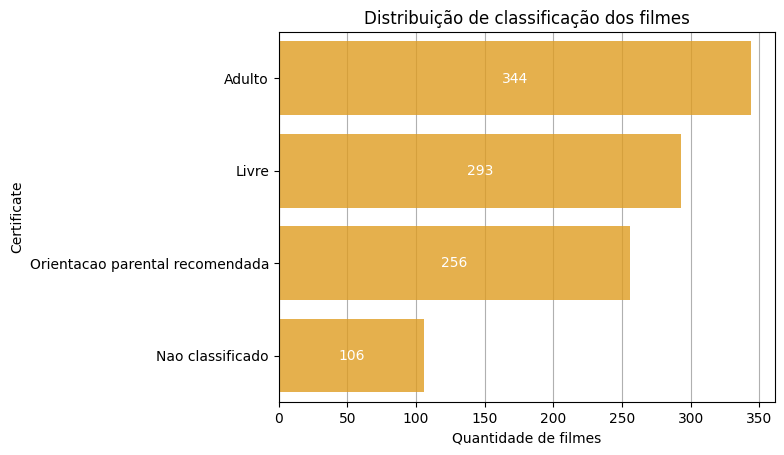

In [98]:
ordem = filmes['Certificate'].value_counts().index
ax = sns.countplot(data = filmes, y = 'Certificate', order = ordem, alpha = 0.8, color='orange')
ax.bar_label(ax.containers[0], color="white", label_type="center")
ax.set_axisbelow(True)
ax.set(title="Distribuição de classificação dos filmes", xlabel="Quantidade de filmes",)
plt.grid(axis='x')
plt.show()

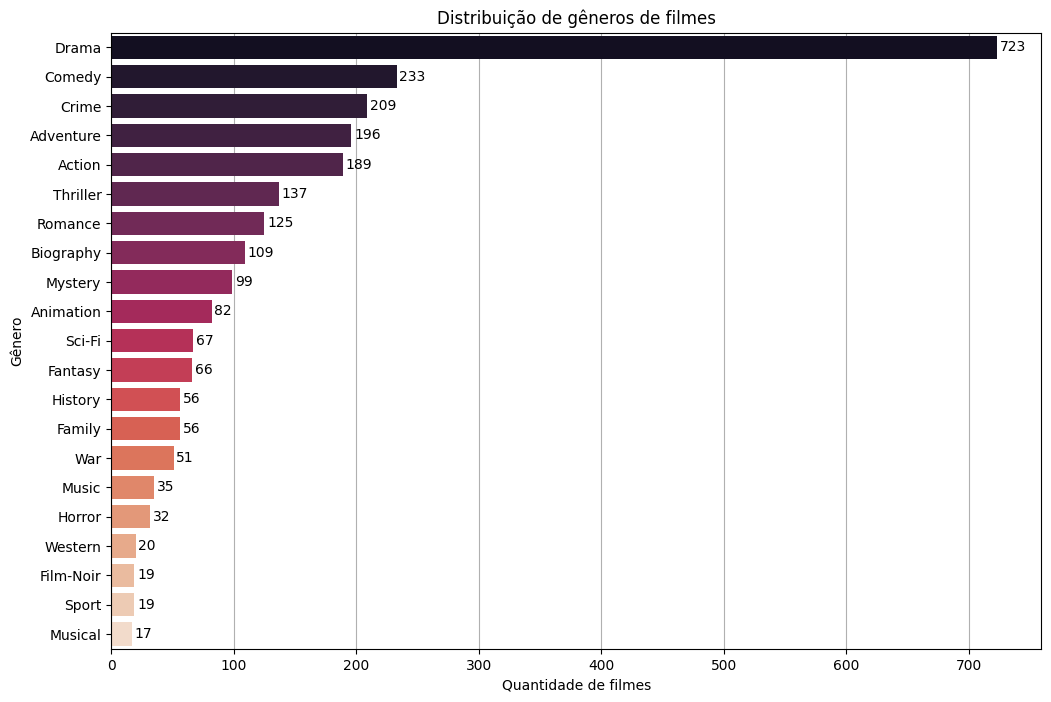

In [99]:
generos_filme = filmes['Genre'].str.split(', ').explode().value_counts() # Contagem dos generos de cada filme separados por virgula 
plt.figure(figsize=(12, 8))

ax = sns.barplot(x=generos_filme.values, y=generos_filme.index, palette='rocket', hue=generos_filme.index, legend=False)
for container in ax.containers:
    ax.bar_label(container, color="black", padding=2)
ax.set_axisbelow(True)
ax.set(title="Distribuição de gêneros de filmes", xlabel="Quantidade de filmes", ylabel='Gênero')

plt.grid(axis='x')
plt.show()


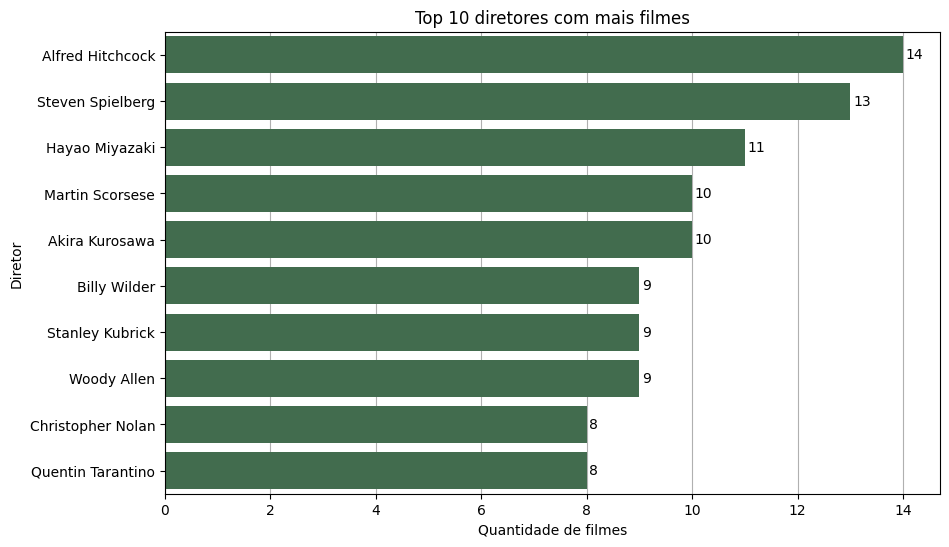

In [100]:
# top10 directors
top10_diretores = filmes['Director'].value_counts().head(10)

plt.figure(figsize=(10, 6))

ax = sns.barplot(x=top10_diretores.values, y=top10_diretores.index, color="#3B734B")
for container in ax.containers:
    ax.bar_label(container, color="black", padding=2)
ax.set_axisbelow(True)
ax.set(title="Top 10 diretores com mais filmes", xlabel="Quantidade de filmes", ylabel='Diretor')

plt.grid(axis='x')
plt.show()

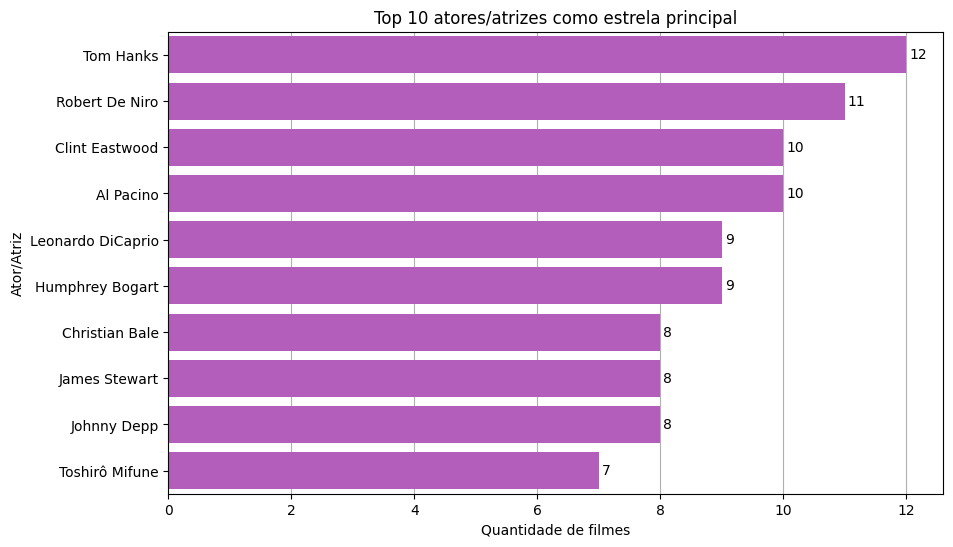

In [101]:
# top10 1st stars 
top10_diretores = filmes['Star1'].value_counts().head(10)

plt.figure(figsize=(10, 6))

ax = sns.barplot(x=top10_diretores.values, y=top10_diretores.index, color="#C04ECA")
for container in ax.containers:
    ax.bar_label(container, color="black", padding=2)
ax.set_axisbelow(True)
ax.set(title="Top 10 atores/atrizes como estrela principal", xlabel="Quantidade de filmes", ylabel='Ator/Atriz')

plt.grid(axis='x')
plt.show()

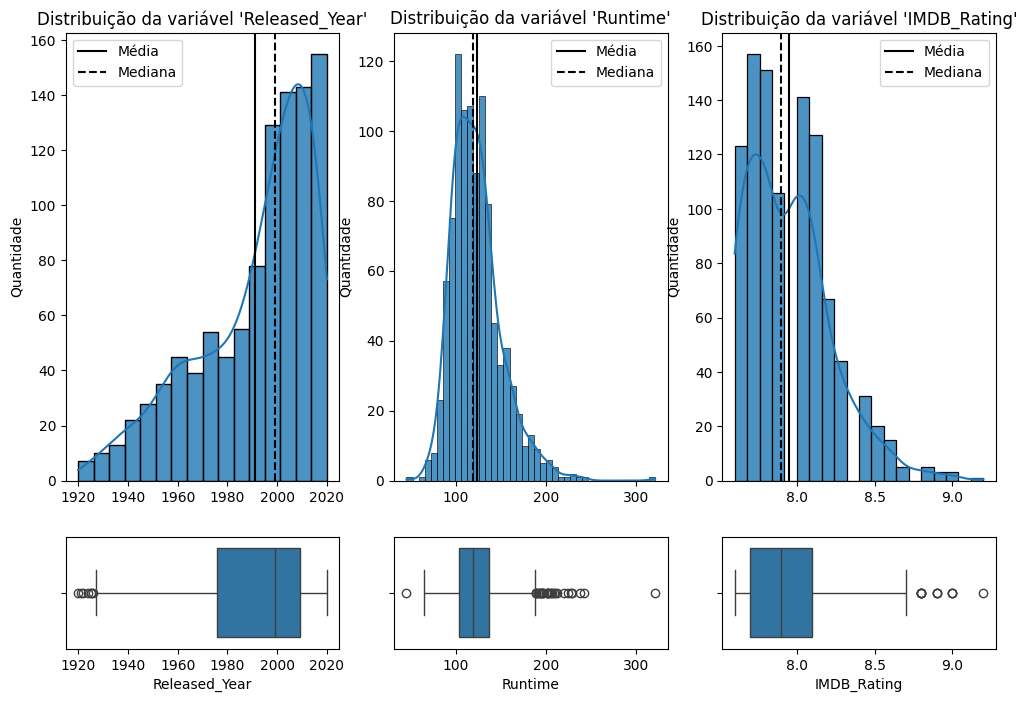

In [102]:
variaveis_quantitativas1 = ['Released_Year', 'Runtime', 'IMDB_Rating']
variaveis_quantitativas2 = ['Meta_score', 'No_of_Votes', 'Gross']

fig, axes = plt.subplots(figsize=(12,8), ncols=3, nrows=2, gridspec_kw={"height_ratios": [4, 1]})

for i, variavel in enumerate(variaveis_quantitativas1):
    ax1 = sns.histplot(data=filmes, x=variavel, ax=axes[0, i], alpha=0.8, kde=True)
    ax1.axvline(filmes[variavel].mean(), color='black', label="Média")
    ax1.axvline(filmes[variavel].median(), color='black', linestyle="--", label="Mediana")
    ax1.set(title=f"Distribuição da variável '{variavel}'", ylabel="Quantidade", xlabel='')
    ax1.legend()


    ax2 = sns.boxplot(data=filmes, x=variavel, ax=axes[1, i])



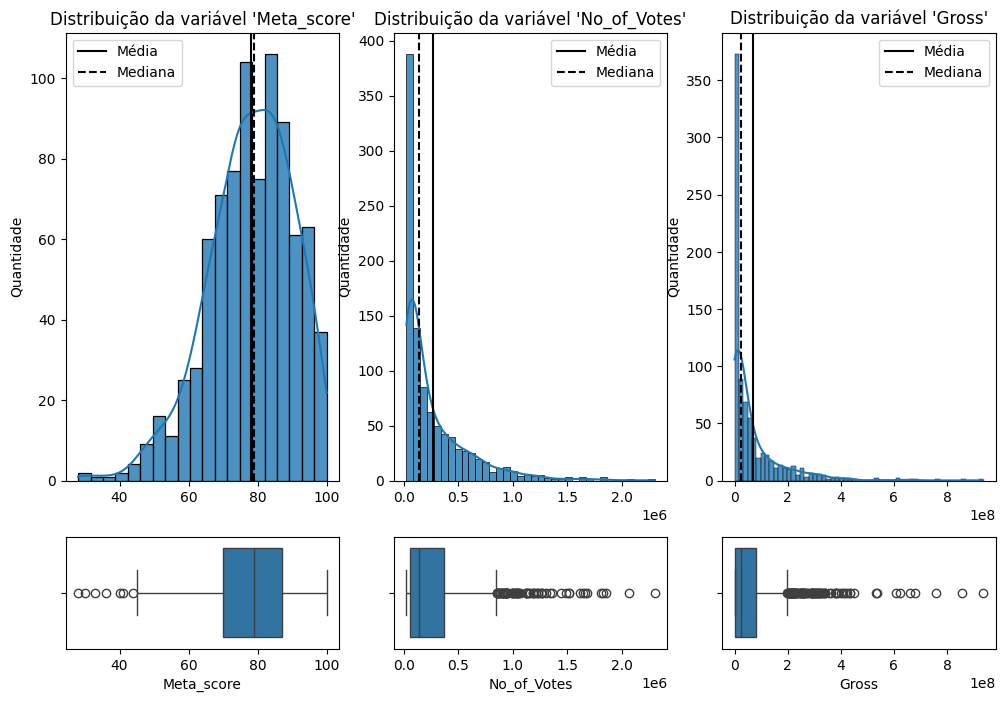

In [103]:
fig, axes = plt.subplots(figsize=(12,8), ncols=3, nrows=2, gridspec_kw={"height_ratios": [4, 1]})

for i, variavel in enumerate(variaveis_quantitativas2):
    ax1 = sns.histplot(data=filmes, x=variavel, ax=axes[0, i], alpha=0.8, kde=True)
    ax1.axvline(filmes[variavel].mean(), color='black', label="Média")
    ax1.axvline(filmes[variavel].median(), color='black', linestyle="--", label="Mediana")
    ax1.set(title=f"Distribuição da variável '{variavel}'", ylabel='Quantidade', xlabel='')
    ax1.legend()


    ax2 = sns.boxplot(data=filmes, x=variavel, ax=axes[1, i])

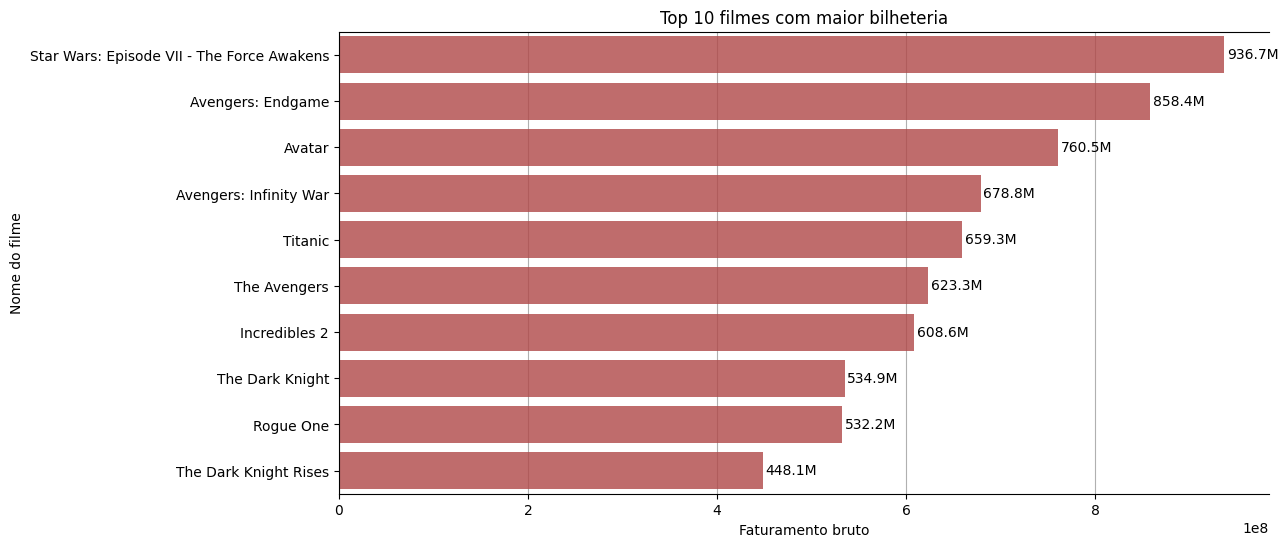

In [104]:
top10_gross = filmes.sort_values(by='Gross', ascending=False).head(10)
plt.figure(figsize=(12,6))

ax = sns.barplot(x=top10_gross['Gross'], y=top10_gross['Series_Title'], color="#C13535BA", alpha = 0.8)

ax.set_axisbelow(True)
ax.set(title="Top 10 filmes com maior bilheteria", xlabel="Faturamento bruto", ylabel="Nome do filme")

labels = top10_gross['Gross'] / 1_000_000
labels = labels.map(lambda x:f'{x:.1f}M')

ax.bar_label(ax.containers[0], color = 'black', labels=labels,padding= 2, fmt='%d')
ax.spines['right'].set_visible(False)
plt.grid(axis='x')
plt.show()

#### Análise bivariada

[]

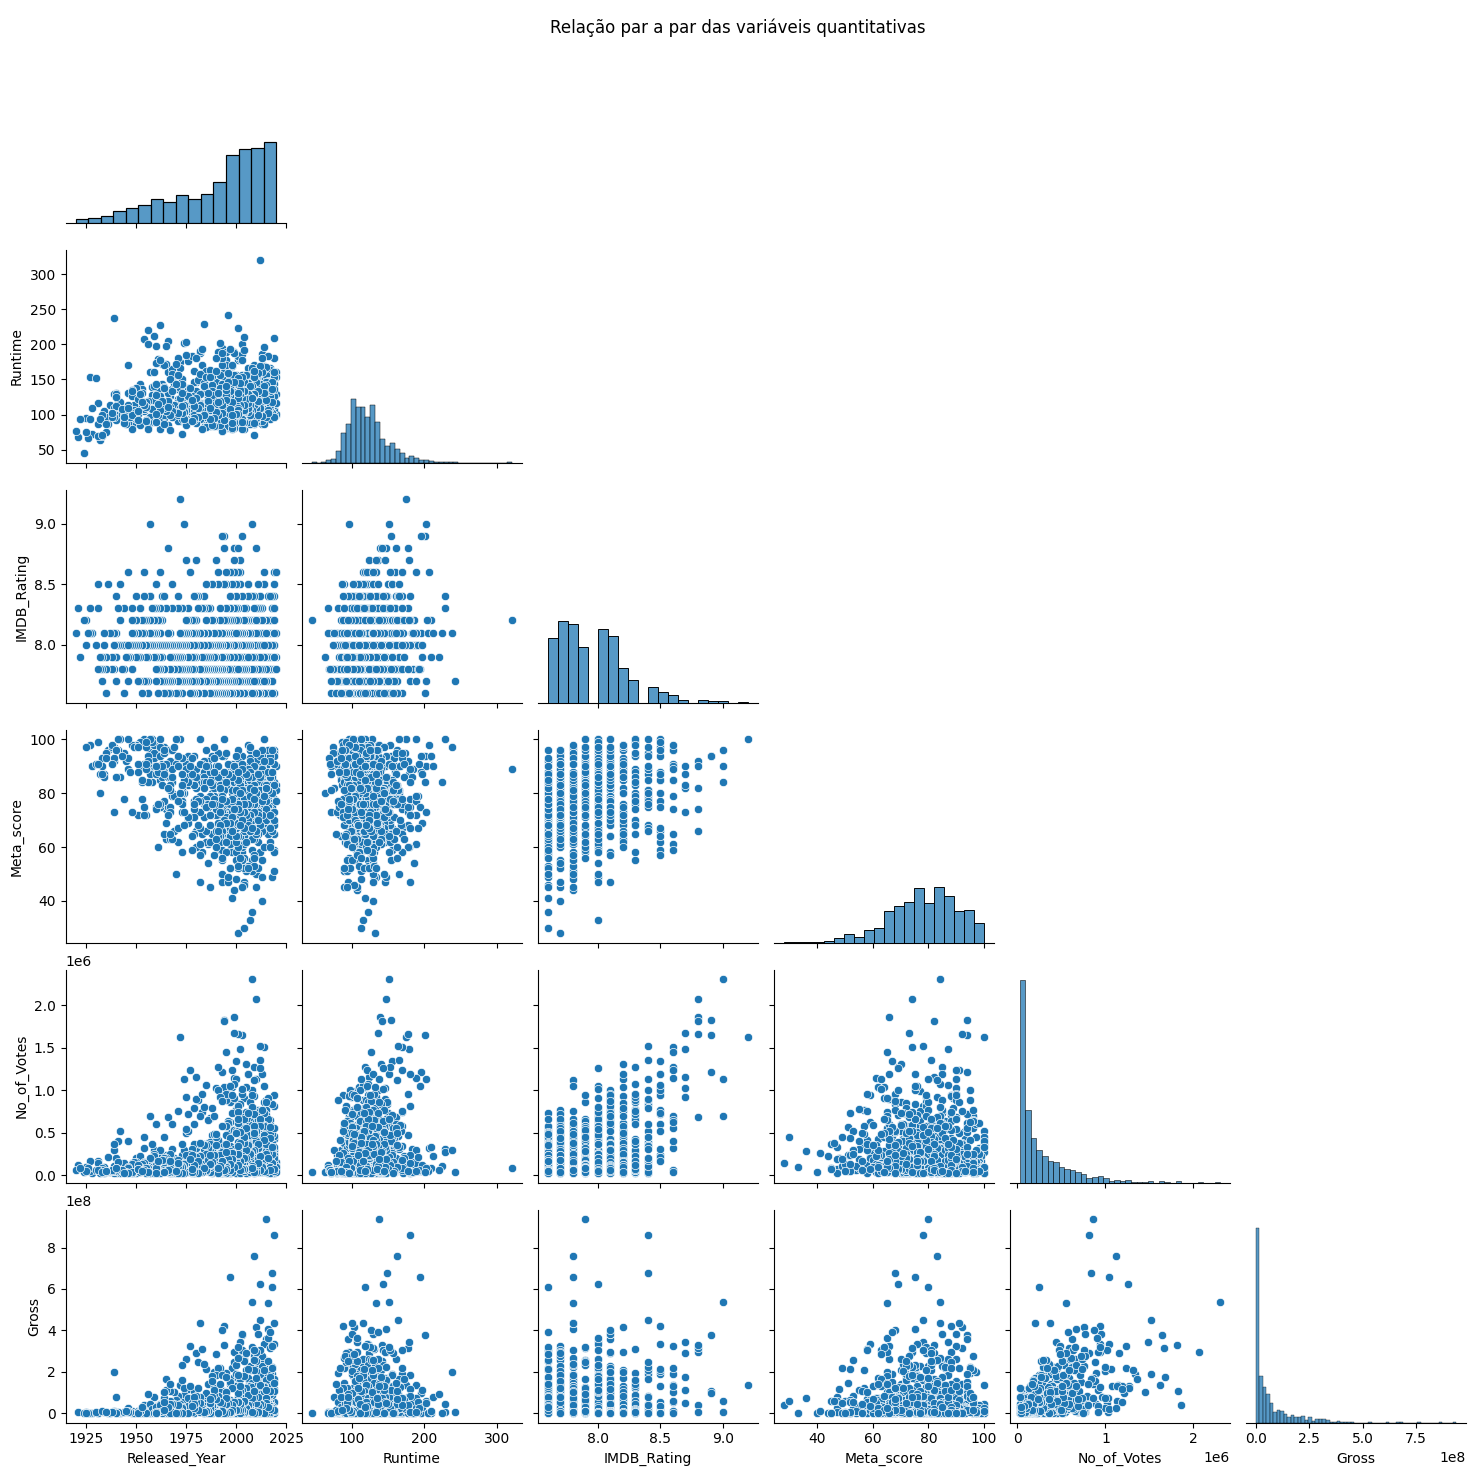

In [105]:
sns.pairplot(data=filmes, corner=True)
plt.suptitle("Relação par a par das variáveis quantitativas")
plt.plot()

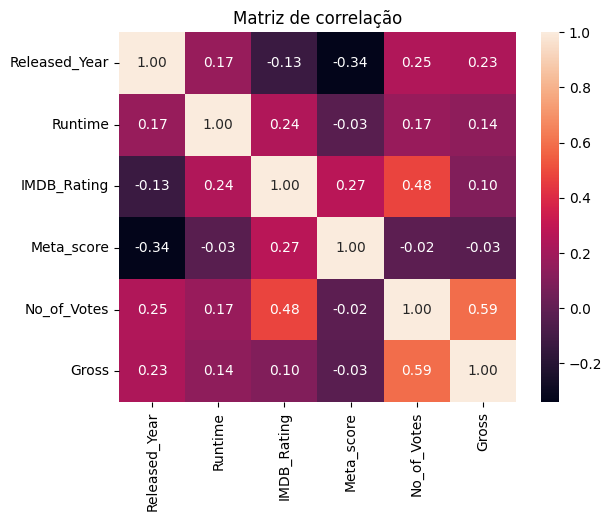

In [106]:
filmes_num = filmes[['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']]
matriz_corr = filmes_num.corr()
sns.heatmap(matriz_corr, fmt=".2f", annot=True)
plt.title('Matriz de correlação')
plt.show()

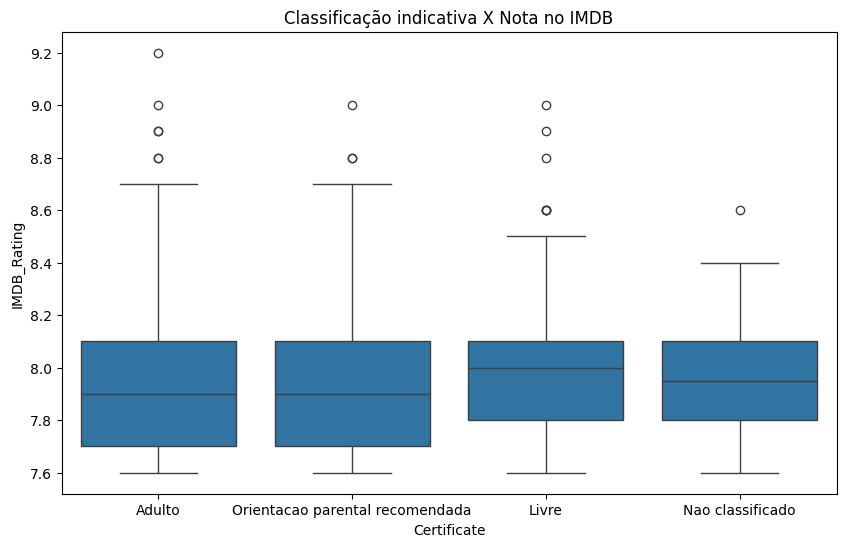

In [107]:
plt.figure(figsize=(10,6))
plt.title('Classificação indicativa X Nota no IMDB')
ax = sns.boxplot(data=filmes, y='IMDB_Rating', x='Certificate')


#### Transformações finais

Verificando a existência de duplicatas

In [108]:
filmes.duplicated().sum()

np.int64(0)

Tratando dados ausentes

In [109]:
filmes[filmes['Gross'].isnull()]['Released_Year'].mean() # Data de lançamento médio das entradas com renda bruta faltantes

np.float64(1977.9526627218936)

Como a data média é em torno de 1978, podemos pressupor que a falta desses valores podem ser explicados por serem filmes mais antigos, o que caracteriza um contexto de dados MNAR(Missing Not At Random). Por isso, irei utilizar o KNNImputer para fazer a imputação desses dados baseados num modelo KNN, que leva em conta o contexto das colunas numéricas passadas para fazer a aferição do valor faltante. 

In [ ]:
colunas_numericas = ['Released_Year', 'Runtime', 'IMDB_Rating', 'Meta_score', 'Gross', 'No_of_Votes']
imputer = KNNImputer()
imputer.fit(filmes[colunas_numericas])
filmes_imputado = pd.DataFrame(imputer.transform(filmes[colunas_numericas]), columns=colunas_numericas)

filmes['Imputed_Gross'] = filmes_imputado['Gross']
filmes['Imputed_Meta_score'] = filmes_imputado['Meta_score']


Vamos modelar a coluna 'Genre' de modo que cada gênero único recebe uma coluna própria com um valor booleano, ou seja, se o filme A têm generos 'Drama, Romance', nas colunas 'Drama' e 'Romance' teria valor True(ou 1) e nas demais valor False(ou 0).

In [111]:
generos_unicos = filmes['Genre'].str.get_dummies(sep=', ')
filmes = pd.concat([filmes.drop('Genre', axis=1), generos_unicos], axis=1)
filmes.head()


,Series_Title,Released_Year,Certificate,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Godfather,1972,Adulto,175.0,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,...,0,0,0,0,0,0,0,0,0,0
1,The Dark Knight,2008,Orientacao parental recomendada,152.0,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,...,0,0,0,0,0,0,0,0,0,0
2,The Godfather: Part II,1974,Adulto,202.0,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,...,0,0,0,0,0,0,0,0,0,0
3,12 Angry Men,1957,Livre,96.0,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,...,0,0,0,0,0,0,0,0,0,0
4,The Lord of the Rings: The Return of the King,2003,Livre,201.0,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,...,0,0,0,0,0,0,0,0,0,0


Fazendo one-hot-encoding para outra variavel categórica('Certificate')

In [112]:
filmes = pd.get_dummies(filmes, columns=['Certificate'], drop_first=True)
filmes.head()

,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Certificate_Livre,Certificate_Nao classificado,Certificate_Orientacao parental recomendada
0,The Godfather,1972,175.0,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,0,0,0,0,0,0,0,False,False,False
1,The Dark Knight,2008,152.0,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,...,0,0,0,0,0,0,0,False,False,True
2,The Godfather: Part II,1974,202.0,9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,...,0,0,0,0,0,0,0,False,False,False
3,12 Angry Men,1957,96.0,9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,...,0,0,0,0,0,0,0,True,False,False
4,The Lord of the Rings: The Return of the King,2003,201.0,8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,...,0,0,0,0,0,0,0,True,False,False


In [115]:
filmes.to_csv('dados_filmes_tratados.csv', index = False) # exportando os dados tratados.

# Considerações gerais sobre o dataset

O dataset possui alguns valores faltantes nas colunas 'Gross' e 'Meta_score', que representram o valor bruto arrecadado pelo filme e a nota do filme no Metacritic, respectivamente, além disso existiam alguns valores faltantes na coluna 'Certificate', que foram tratados durante o processo de normalização desse atributo, onde foram atribuidos o valor 'Nao classificado'.


A maioria dos filmes presentes são de classificação adulta, totalizando 344 filmes que se encaixam nessa categoria, fora os que ainda não possuem classificação conhecida. Uma quantidade muito significativa dos filmes possuem temas de Drama(723 títulos), sendo a Comédia o segundo maior gênero em termos de frequência no conjunto de dados. O diretor Alfred Hitchcock é o que mais aparece com 14 filmes produzidos por ele nesse dataset. Análises dos histogramas das variáveis numéricas mostram algumas informações importantes: 

 - A maioria dos filmes foram lançados entre 2000 e 2020, possuem menos de 150 minutos de duração.  
 - As notas mais comuns no IMDB estão dentro do intervalo 7,7 a 8,3, com alguns poucos outliers fora disso.  
 - O Meta-score médio gira em torno de 80 e a grande maioria dos filmes têm uma renda bruta estimada menor do que 50 milhões.

Sobre as variáveis numéricas, é possivel extrair da matriz de confusão que a nota no IMDB possui uma correlação positiva significativa com o número de votos, ou seja, ambas as variáveis tendem a variar juntas. O mesmo podemos observar para o número de votos e a renda bruta(Gross) arrecadada pelo filme, com uma correlação ainda mais forte. Fora isso, existe uma tendencia leve de correlação da nota no IMDB com o Metascore e o tempo de filme, ambos em torno de 0,25

# Respondendo perguntas importantes

1. Qual filme você recomendaria para uma pessoa que você não conhece?

Resposta: Para alguém que não conheço, a melhor estratégia para indicação de filme seria procurar o filme com a maior nota no IMDB e com o maior número de votos possíveis para basear essa nota, ou seja, seria um filme visto positivamente pelo maior número de pessoas. Não usaria a métrica do Metascore, pois ela leva em consideração a opnião de críticos de filme, e não de telespectadores casuais. 

Utilizando essa estratégia, recomendaria o filme The Dark Knight, que tem nota 9,0 no IMDB, com mais de 2 milhões de votos.

In [113]:
filmes['Soma_notas'] = filmes['IMDB_Rating']*filmes['No_of_Votes']
filmes.sort_values(by='Soma_notas', ascending=False).head(1)


,Series_Title,Released_Year,Runtime,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,Romance,Sci-Fi,Sport,Thriller,War,Western,Certificate_Livre,Certificate_Nao classificado,Certificate_Orientacao parental recomendada,Soma_notas
1,The Dark Knight,2008,152.0,9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,...,0,0,0,0,0,0,False,False,True,20729088.0


2. Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

Resposta: O fator que mais está relacionado é a quantidade de votantes no IMDB, seguido pelo ano de lançamento do filme, baseado na matriz de correlação que extraímos nas seções passadas. Tal observação é facil de interpretar, já que, quanto mais pessoas assistiram o filme(o que gera faturamento), mais pessoas votam no IMDB. Também podemos observar que, no caso da data de lançamento, quanto mais recente o filme, maior tende a ser o faturamento, o que é explicado devido ao aumento de popularidade do cinema na população geral, seja na forma de cinemas tradicionais, como também no caso de serviços de streaming e assinaturas de TV. 

In [114]:
matriz_corr['Gross'].sort_values(ascending=False)

Gross            1.000000
No_of_Votes      0.589527
Released_Year    0.233198
Runtime          0.140002
IMDB_Rating      0.099393
Meta_score      -0.030480
Name: Gross, dtype: float64

3. Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna 'Overview', que contém uma breve descrição(sinópse) do filme, pode sim ser usada para definir o gênero do filme, por meio da utilização de modelos de previsão baseados em Processamento de Linguagem Natural(NLP). Podemos realizar o processo de tratamento do texto de descrição(retirando stopwords, aplicando tokenização, lematização, retirando acentos e caracteres especiais, dentre outros), aplicar um algoritmo de vetorização, que transforma os textos tratados em vetores numéricos que podem ser utilizados diretamente em modelos de aprendizagem de máquina clássicos. Farei esse procedimento nesse projeto também. 